# Dynamical Systems Analysis of a Single Neuron Model

In [1]:
%matplotlib nbagg
import functools
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import scipy.integrate as spi
import scipy.optimize as spo
import scipy.interpolate as spolate

In [4]:
def poincaré_map(F, x0s, P, mus, tmax):
    """
    Given a vector field F on R^n, an (m,n) array of m initial
    conditions x0s, a function P which changes sign when the
    trajectory crosses the Poincaré section, and a vector mu
    of bifurcation parameter values, computes the Poincaré map
    for each combination of IC and bifurcation parameter.
    Evaluation attempts time out at t = tmax.

    Returns the return time Tret and the Poincaré map Xpcr.
    """
    P.terminal = True
    Tret = np.zeros((len(mus), len(x0s)))
    Xpcr = np.zeros((len(mus),) + x0s.shape)

    for i, mu in enumerate(mus):
        fun = functools.partial(F, mu)
        for j, x0 in enumerate(x0s):
            out = spi.solve_ivp(fun, (0,tmax), x0, events=P)
            if out.status == 1:
                Tret[i,j] = out.t[-1]
            else:
                Tret[i,j] = np.inf
            Xpcr[i,j,:] = out.y[:,-1]

    return Tret, Xpcr

In [2]:
# Model for cortical RS pyramidal neuron taken from Izhikevich (2007)
C, k = 100, 0.7
vr, vt, vp = -60, -40, 35
a, b, c, d = 0.03, -2, -50, 100

Istar = k/4 * (vr - vt - b/k)**2

def jump_map(t, vu):
    return np.array([c,d]) + np.array([0,1]) * vu

def flow_map(I, t, vu):
    v, u = vu
    vdot = (k*(v - vr)*(v - vt) - u + I)/C
    udot = a * (b * (v - vr) - u)
    return np.array([vdot, udot])

def P(t, vu):
    return vu[0] - vp


In [3]:
# Find the Poincaré map of the neuron
from tqdm import tqdm_notebook as tqdm

tmax = 10000
u0s = np.linspace(-100, 500, num=21)
mus = np.geomspace(1, 1000, num=71)
x0s = jump_map(0, np.array([vp + 0*u0s, u0s]).T)

Tret, Xpcr = poincaré_map(flow_map, x0s, P, tqdm(mus), tmax=tmax)

### Saddle-Node Bifurcation
Demonstrates the saddle-node bifurcation of the resting state, which converges with the threshold then eventually disappears as input current increases. For these parameters, this occurs at $I = 51.4\text{pA}$.

In [5]:


def bifurcation_diagram(f, fx, x, mu):
    "Plot a bifurcation diagram of a 1D dynamical system."
    xx = x.reshape((-1,1))
    mumu = mu.reshape((1,-1))
    fvals = f(xx, mumu)
    fxvals = fx(xx, mumu)
    fvalsP = np.ma.masked_where(fxvals<0, fvals)
    plt.contour(mu, x, fvals, levels=[0], colors='k')
    plt.contour(mu, x, fvalsP, levels=[0], colors='r')
    plt.xlabel('$\mu^*$')

<IPython.core.display.Javascript object>


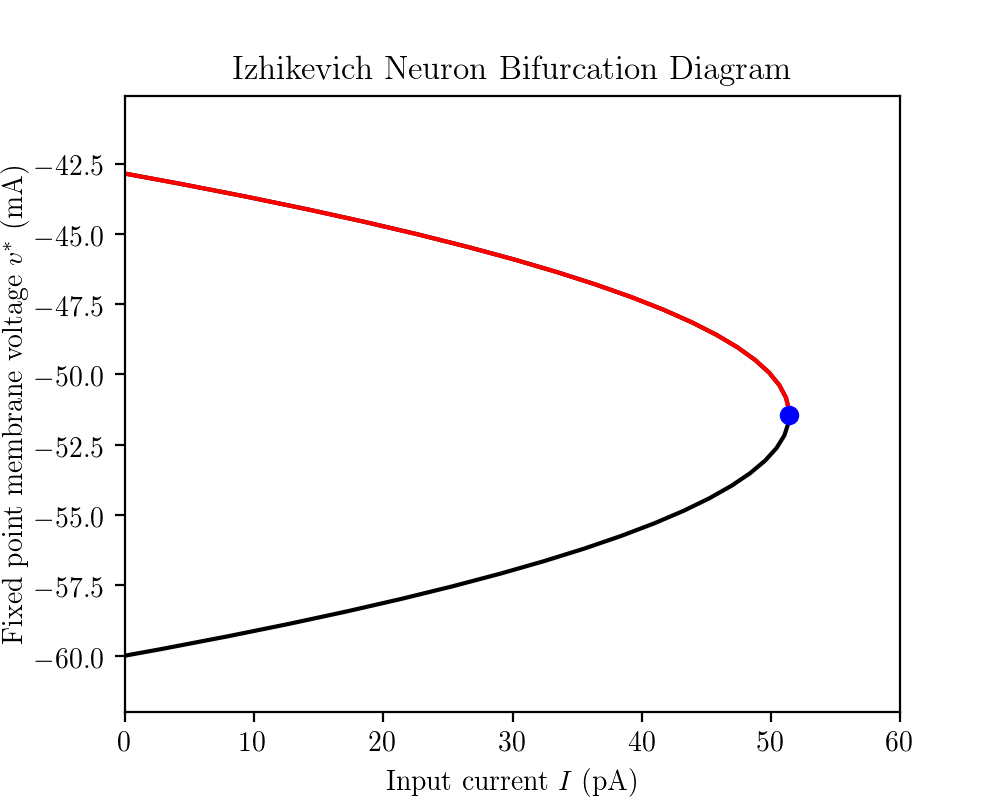

Text(0.5, 1.0, 'Izhikevich Neuron Bifurcation Diagram')

In [6]:
# Restriction of the system to the u nullcline.
def f(v,I):
    return (k*(v - vr)*(v - vt - b/k) + I)/C

# 1D system derivative wrt v
def fv(v,I):
    return k/C * (2*v - vr - vt - b/k) + 0*I

plt.figure(figsize=(5,4))
bifurcation_diagram(f, fv, np.linspace(-62, -40.1), np.linspace(0,60))
plt.plot(k*(vr - vt - b/k)**2 / 4, (vr + vt + b/k)/2, 'bo')
plt.xlabel('Input current $I$ (pA)')
plt.ylabel('Fixed point membrane voltage $v^*$ (mA)', labelpad=2)
plt.title('Izhikevich Neuron Bifurcation Diagram')

### The I-F Relation
The Poincaré and return-time maps are used to calculate how firing frequency changes with input current, for a constant input from the beginning of time (or after an initial transient). Two particular observations of interest are that (1) these RS neurons appear to exhibit class-I neural excitability, in that their firing frequency increases smoothly and varies over a wide range as input current increases, and (2) the firing frequency appears to follow approximately a 0.75-power law. 

(By the way, a previous version claimed that a source quoted a logarithmic scaling and attempted to reproduce it, but the reason it didn't work was that that result was for a model which undergoes a homoclinic orbit bifurcation, not the saddle node on invariant cycle which this neuron undergoes.)

In [7]:
# Find the fixed points and return times of the Poincaré map.
ustars = np.zeros_like(mus)
tstars = np.zeros_like(mus)

Upcr = Xpcr[:,:,1]
guesses = np.argmin(np.abs(Upcr - u0s), axis=1)

mupoints = np.tile(mus.reshape((-1,1)), (1,len(u0s)))[np.isfinite(Tret)]
u0points = np.tile(u0s.reshape((1,-1)), (len(mus),1))[np.isfinite(Tret)]
uvals = Upcr[np.isfinite(Tret)]
Pinterp = spolate.SmoothBivariateSpline(mupoints, u0points, uvals)

for i,mu in enumerate(mus):
    ustars[i] = spo.fixed_point(lambda u: Pinterp(mu, u), guesses[i])
    
    x0 = jump_map(0, np.array([[vp, ustars[i]]]))
    tstars[i] = poincaré_map(flow_map, x0, P, [mu], tmax=tmax)[0]

In [8]:
# Find closest linear fit to frequency, i.e. 1/I fit to period.
finites = np.isfinite(tstars)
if np.any(finites):
    alpha = np.poly1d(np.polyfit(mus[mus > 200], 1/tstars[mus > 200], deg=1))
else:
    alpha = lambda mus: mus*0


In [9]:
# Find a fit of the form a*r(I - I0)^k.
I0 = 51.4
def monom(params, mus):
    a, k = params
    out = np.zeros_like(mus)
    out[mus >= I0] = a * (mus[mus >= I0] - I0)**k
    return out

monom_params = spo.fmin(lambda params: np.sum((monom(params, mus[mus > 200])
                                               - 1/tstars[mus > 200])**2),
                        np.array([1e-4, 0.8]))
print(monom_params)

Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 95
         Function evaluations: 175
[0.0008502  0.75202044]


<IPython.core.display.Javascript object>


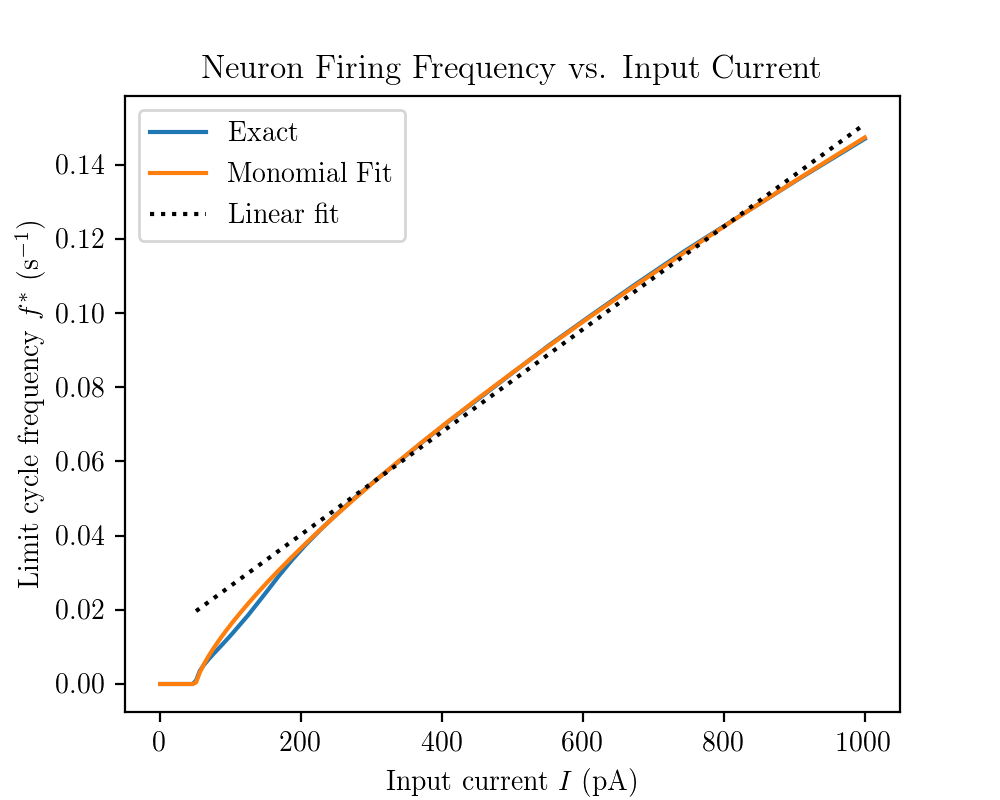

In [10]:
plt.figure(figsize=(5,4))
plt.plot(mus, 1/tstars, label='Exact')
plt.plot(mus, monom(monom_params, mus), label='Monomial Fit')
plt.plot(mus[finites], alpha(mus[finites]), 'k:', label='Linear fit')
plt.legend()
plt.xlabel('Input current $I$ (pA)')
plt.ylabel('Limit cycle frequency $f^*$ (s$^{-1}$)')
plt.title('Neuron Firing Frequency vs. Input Current')
xlim = plt.xlim()

### Simulation Across Multiple Firings
Above, we have terminated the simulation immediately when a cell fires. Here, a function is introduced which simulates the cell up to a given time regardless of the number of firings.

In [ ]:
def hybrid_sim(flow_map, jump_map, jump_event, x0, t_range, max_jumps, other_events=()):
    """
    Given a hybrid system in the form of the following components:
        flow_map(t, x) -> dx/dt
        jump_map(t, x) -> x+
        jump_event(t, x) -> continuous, positive inside the
                            jump set, negative outside

    Computes a solution from the initial condition x0 over the
    evaluation range t_range = (t_start, t_stop) or up to the 
    maximum number of jumps max_jumps, whichever comes first.

    Can also take other_events, an optional list of events to
    track; the times at which these events occur DURING FLOW
    are recorded and returned. 

    Returns
        tout : the evaluation times in a hybrid time domain
        Xout : the state trajectory corresponding to those times
        tev : the times at which each custom event occurred
    """
    jump_event.terminal = True
    jump_event.direction = 1
    events = (jump_event,) + other_events

    xouts = []
    touts = []
    tev = [[] for _ in events]

    i = 0
    jumps = 0
    while jumps < max_jumps:
        # Compute and save the results until an event or the end.
        res = spi.solve_ivp(flow_map, t_range, x0, events=events)

        # Save the latest portion of the state trajectory.
        xouts.append(res.y)

        # Save the evaluation times in a hybrid time domain.
        thist = np.vstack((res.t, np.ones_like(res.t) * jumps))
        touts.append(thist)

        # Save all the event times.
        for i, arr in enumerate(res.t_events):
            tev[i] += list(arr)

        # Done because of failure or reaching t_stop.
        if res.status==0 or res.status==-1: break

        # Not done, so jump. Awkward syntax because if multiple jumps
        # occur in sequence, one will be automatically entered into 
        x0 = jump_map(res.t[-1], res.y[:,-1])
        jumps += 1
        
        while jump_event(res.t[-1], x0) >= 0:
            x0 = jump_map(res.t[-1], x0)
            jumps += 1
        t_range = res.t[-1], t_range[1]

    touts = np.hstack(touts)
    xouts = np.hstack(xouts)
    return touts, xouts.T, tev


<IPython.core.display.Javascript object>


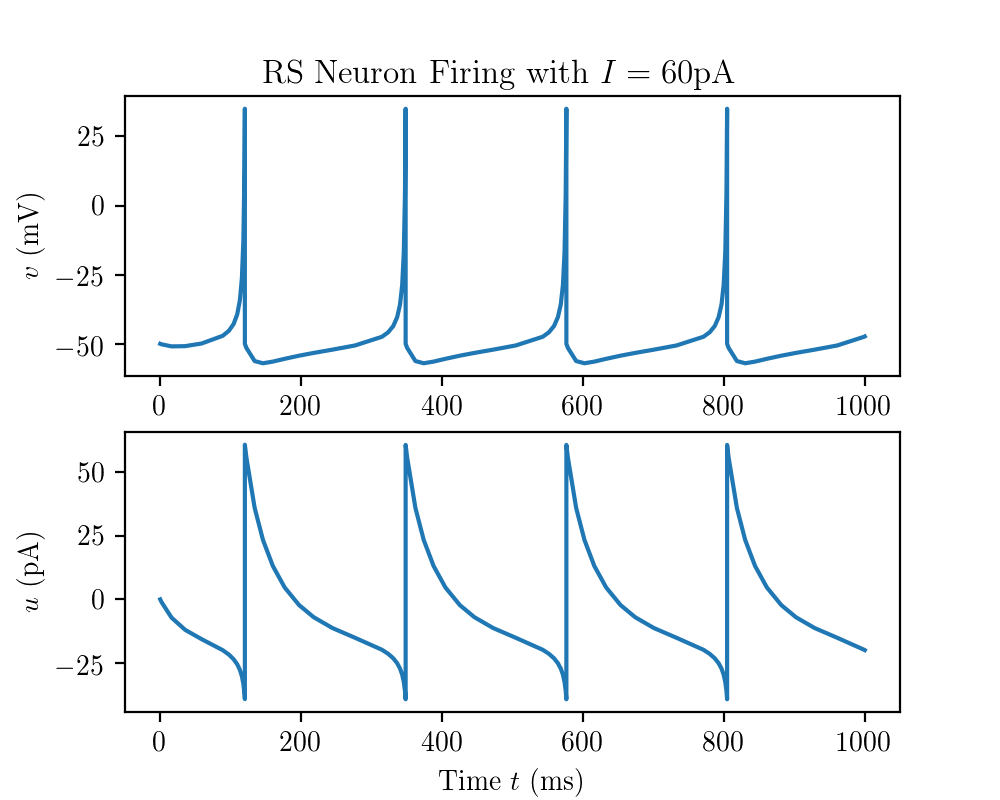

Text(0.5, 0.925, 'RS Neuron Firing with $I = 60\\mathrm{pA}$')

In [11]:
Itest = 60#pA
x0 = np.array([(vr + vt)/2, 0])
the_flow = functools.partial(flow_map, Itest)
tout, xout, tev = hybrid_sim(the_flow, jump_map, P, 
                             (0,1000), x0)

plt.figure(figsize=(5,4))

plt.subplot(211)
plt.plot(tout[0,:], xout[:,0])
plt.ylabel('$v$ (mV)')
plt.subplot(212)
plt.plot(tout[0,:], xout[:,1])
plt.ylabel('$u$ (pA)')

plt.xlabel('Time $t$ (ms)')
plt.suptitle('RS Neuron Firing with $I = {}\\mathrm{{pA}}$'.format(Itest), y=0.925)

# Bibliography

Izhikevich E. M. (2007). _Dynamical Systems in Neuroscience_. MIT press.
> Source of the model of the cortical RS neuron used here.
